First few rows of the DataFrame:
   Input      kP   kI   kD  Output
0    320  0.0375  0.0  0.0  12.000
1    310  0.0375  0.0  0.0  11.625
2    300  0.0375  0.0  0.0  11.250
3    290  0.0375  0.0  0.0  10.875
4    280  0.0375  0.0  0.0  10.500


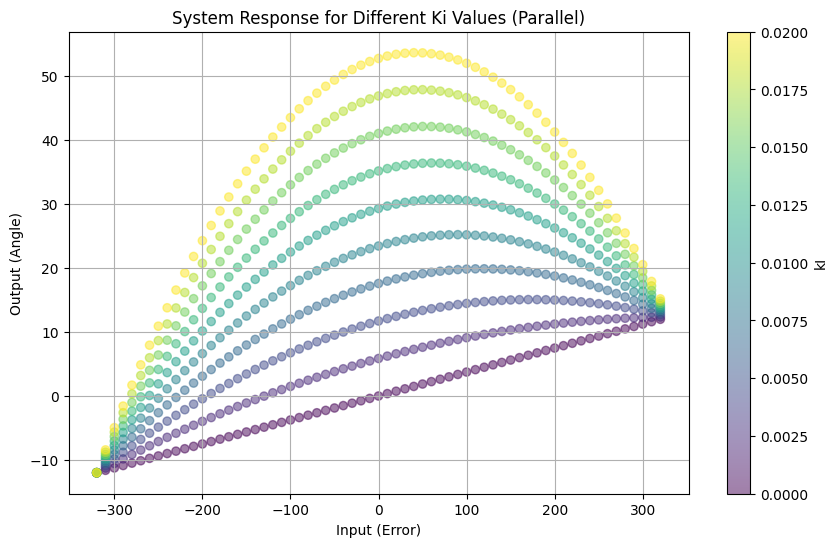

Last few rows of the DataFrame:
     Input      kP    kI   kD  Output
645   -280  0.0375  0.02  0.0   1.700
646   -290  0.0375  0.02  0.0  -1.575
647   -300  0.0375  0.02  0.0  -4.950
648   -310  0.0375  0.02  0.0  -8.425
649   -320  0.0375  0.02  0.0 -12.000
Identified ki values:
[0.         0.00222222 0.00444444 0.00666667 0.00888889 0.01111111
 0.01333333 0.01555556 0.01777778 0.02      ]


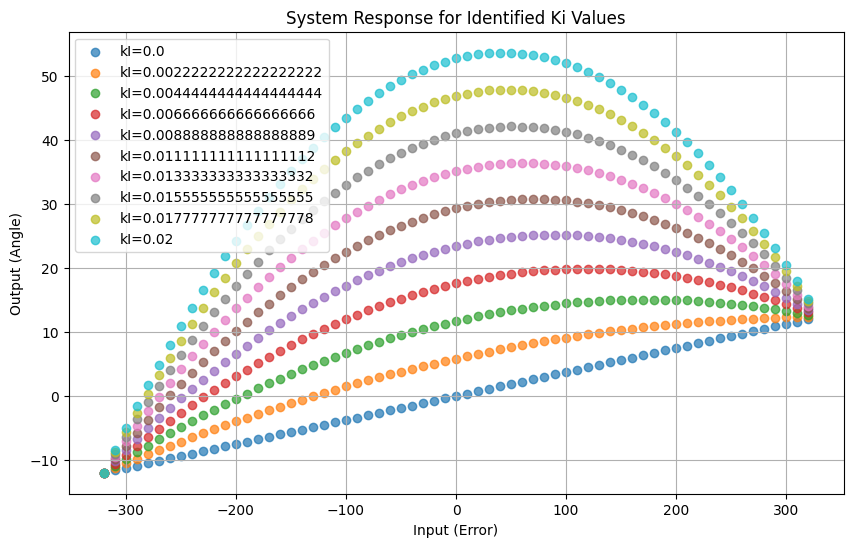

Data saved to tuning_results_ki_variation_kp0.0375.xlsx


In [3]:
import pandas as pd
import numpy as np
from pid_sm import PIDController
import concurrent.futures
import matplotlib.pyplot as plt

# Function to simulate the system response using the PID controller
def simulate_system_response(params):
    kp, ki, kd, setpoint, object_centers = params
    pid_controller = PIDController(kP=kp, kI=ki, kD=kd)
    pid_controller.reset()

    data = {'Input': [], 'kP': [], 'kI': [], 'kD': [], 'Output': []}

    for object_center in object_centers:
        error = setpoint - object_center
        output = pid_controller.update(error)

        # Append values to the data dictionary
        data['Input'].append(error)
        data['kP'].append(kp)
        data['kI'].append(ki)
        data['kD'].append(kd)
        data['Output'].append(output)

    return pd.DataFrame(data)

# Generate input values
object_centers = np.arange(0, 641, 10)

# Define the range for kp and ki values
kp_values = np.linspace(0.0375, 0.0375, 1)  # Keeping kp constant at 1.5
ki_values = np.linspace(0.0, 0.02, 10)  # Varying ki from 0.01 to 5.0
#kd_values = np.linspace(0.0, 0.5, 10)

# Setpoint for all cases
setpoint = 320

# Create parameter combinations
parameter_combinations = [(kp, ki, 0.0, setpoint, object_centers)
                          for kp in kp_values
                          for ki in ki_values]

# Use concurrent.futures for parallel execution
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(simulate_system_response, parameter_combinations))

# Combine results from all executions
df = pd.concat(results, ignore_index=True)

# Save the data to an Excel file
excel_filename = 'tuning_results_ki_variation_kp0.0375.xlsx'
df.to_excel(excel_filename, index=False)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['Input'], df['Output'], c=df['kI'], cmap='viridis', marker='o', alpha=0.5)
plt.title('System Response for Different Ki Values (Parallel)')
plt.xlabel('Input (Error)')
plt.ylabel('Output (Angle)')
plt.colorbar(label='kI')
plt.grid(True)
plt.show()

# Display the last few rows of the DataFrame
print("Last few rows of the DataFrame:")
print(df.tail())

# Filter the DataFrame based on desired behavior
filtered_df = df[(df['Input'] >= -320) & (df['Input'] <= 320) & (df['Output'] >= -60) & (df['Output'] <= 60)]

# Get unique ki values that satisfy the condition
desired_ki_values = filtered_df['kI'].unique()

# Display the identified ki values
print("Identified ki values:")
print(desired_ki_values)

# Plot for identified ki values
plt.figure(figsize=(10, 6))
for ki_value in desired_ki_values:
    plt.scatter(filtered_df[filtered_df['kI'] == ki_value]['Input'],
                filtered_df[filtered_df['kI'] == ki_value]['Output'],
                label=f'kI={ki_value}', alpha=0.7)

plt.title('System Response for Identified Ki Values')
plt.xlabel('Input (Error)')
plt.ylabel('Output (Angle)')
plt.legend()
plt.grid(True)
plt.show()

print(f'Data saved to {excel_filename}')
